<a href="https://colab.research.google.com/github/Joykareko/Data-Science-Projects/blob/main/Kenyas_Politics_Sentiment_Analysis_ML_Project_10.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [35]:
#importing the dependencies
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score

In [36]:
from textblob import TextBlob
from wordcloud import WordCloud

In [37]:
#loading the data
election_data = pd.read_csv('/content/kenya_political_tweets.csv')
election_data.head(3)

,id,user_name,user_location,user_description,user_created,user_followers,user_friends,user_favourites,user_verified,date,text,hashtags,source,retweets,favorites,is_retweet
0,1396091006030856192,Doomster,Utopia slums,"Alt-left, liberal, pronoun:them",2009-08-23 12:22:53,309,907,8050,False,2021-05-22 13:10:08,@PrettyAmmina The change to the new blue unifo...,NaN,Twitter Web App,0.0,0.0,False
1,1395981137764397056,Unruly 🗯,Morayfield,I don't know what you thought this was gonna b...,2011-04-20 19:35:54,1053,523,5279,False,2021-05-22 05:53:33,I think it's now safe to say President Uhuru K...,NaN,Twitter for Android,0.0,0.0,False
2,1395433210490798082,Khavin,Nairobi,CCTV installation and MAINTENANCE technician. ...,2020-02-11 04:52:44,4202,3735,29563,False,2021-05-20 17:36:17,@_CrazyKenyan President Uhuru Kenyatta bribed ...,['bbinonsense'],Twitter Web App,0.0,1.0,False


In [38]:
#checking the rows and columns
election_data.shape

(11723, 16)

In [39]:
#checking the general info
election_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11723 entries, 0 to 11722
Data columns (total 16 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   id                11723 non-null  object 
 1   user_name         11723 non-null  object 
 2   user_location     9239 non-null   object 
 3   user_description  10730 non-null  object 
 4   user_created      11722 non-null  object 
 5   user_followers    11722 non-null  object 
 6   user_friends      11722 non-null  object 
 7   user_favourites   11722 non-null  object 
 8   user_verified     11721 non-null  object 
 9   date              11722 non-null  object 
 10  text              11722 non-null  object 
 11  hashtags          1174 non-null   object 
 12  source            11722 non-null  object 
 13  retweets          11721 non-null  float64
 14  favorites         11721 non-null  float64
 15  is_retweet        11721 non-null  object 
dtypes: float64(2), object(14)
memory usage: 

In [40]:
#missing values?
election_data.isnull().sum()

id                      0
user_name               0
user_location        2484
user_description      993
user_created            1
user_followers          1
user_friends            1
user_favourites         1
user_verified           2
date                    1
text                    1
hashtags            10549
source                  1
retweets                2
favorites               2
is_retweet              2
dtype: int64

In [41]:
#interested in user loaction and text
election_data['user_location'].value_counts()

Nairobi, Kenya       2954
Kenya                1189
Nairobi               558
Limuru, Kenya         186
Mombasa, Kenya        173
                     ... 
nyandarua               1
Meru, India             1
Mombasa ✈ Meru          1
Nairobi, Garissa        1
ndio ukule fare🤔🤔       1
Name: user_location, Length: 986, dtype: int64

In [42]:
election_data['user_name'].value_counts()

Who is John Galt?             185
Kings Research Consultancy    129
Nation Africa                 116
Abuga Makori EGH, MBE          87
The Standard Digital           81
                             ... 
Erick Kanyeki Ngure             1
Killa Lando                     1
Swam Technologies®️             1
Call of Dhootie                 1
Peter Abonyo                    1
Name: user_name, Length: 4198, dtype: int64

In [43]:
#replacing the null values in 'text' column with empty strings
#replacing the null values in 'location' column with mode
election_data.fillna(value = {'text':' ','user_location':'Nairobi'},inplace = True)
election_data.isnull().sum()

id                      0
user_name               0
user_location           0
user_description      993
user_created            1
user_followers          1
user_friends            1
user_favourites         1
user_verified           2
date                    1
text                    0
hashtags            10549
source                  1
retweets                2
favorites               2
is_retweet              2
dtype: int64

Cleaning the Data

In [44]:
#cleaning the text column which will be our main analysis
election_dataset = election_data.drop(columns = ['id','user_name','user_location','user_description','user_created',
                                      'user_followers','user_friends','user_favourites','user_verified','date','hashtags','source',
                                      'retweets','favorites','is_retweet'],axis = 1)
election_dataset.head(3)

,text
0,@PrettyAmmina The change to the new blue unifo...
1,I think it's now safe to say President Uhuru K...
2,@_CrazyKenyan President Uhuru Kenyatta bribed ...


In [45]:
#cleaning the data step 1 by removing tags ,@, RT
def CleanTxt(text):
    text = re.sub(r'@[A-Za-z0-9]+','',text) #removes @mentions and substitutes with an empty string
    text = re.sub(r'@_','',text)
    text = re.sub(r'#','', text) #removes #tags
    text = re.sub(r'RT[\s]+','',text) #removes the RT
    text = re.sub(r'https?:\/\/\S+','',text)
    
    return text

election_dataset['Cleaned Text'] = election_dataset['text'].apply(CleanTxt)
election_dataset.head(3)

,text,Cleaned Text
0,@PrettyAmmina The change to the new blue unifo...,The change to the new blue uniforms was order...
1,I think it's now safe to say President Uhuru K...,I think it's now safe to say President Uhuru K...
2,@_CrazyKenyan President Uhuru Kenyatta bribed ...,CrazyKenyan President Uhuru Kenyatta bribed MC...


In [58]:
import nltk
nltk.download('punkt')
from nltk.tokenize import word_tokenize
from nltk import pos_tag
nltk.download('stopwords')
from nltk.corpus import stopwords
nltk.download('wordnet')
from nltk.corpus import wordnet
import nltk
nltk.download('averaged_perceptron_tagger')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


True

In [51]:
# POS tagger dictionary
#pos_dict = {'J':wordnet.ADJ, 'V':wordnet.VERB, 'N':wordnet.NOUN, 'R':wordnet.ADV}
#def token_stop_pos(text):
    #tags = pos_tag(word_tokenize(text))
    #newlist = []
    #for word, tag in tags:
        #if word.lower() not in set(stopwords.words('english')):
          #newlist.append(tuple([word, pos_dict.get(tag[0])]))
        #return newlist

#election_dataset['POS tagged'] = election_dataset['Cleaned Text'].apply(token_stop_pos)
#election_dataset.head(3)

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.


,text,Cleaned Text,POS tagged
0,@PrettyAmmina The change to the new blue unifo...,The change to the new blue uniforms was order...,[]
1,I think it's now safe to say President Uhuru K...,I think it's now safe to say President Uhuru K...,[]
2,@_CrazyKenyan President Uhuru Kenyatta bribed ...,CrazyKenyan President Uhuru Kenyatta bribed MC...,"[(CrazyKenyan, n)]"


In [56]:
#election_dataset.tail(3)

,text,Cleaned Text,POS tagged
11720,If William Ruto and Uhuru Kenyatta could not m...,If William Ruto and Uhuru Kenyatta could not m...,[]
11721,DP William Ruto has criticized proponents of B...,DP William Ruto has criticized proponents of B...,"[(DP, n)]"
11722,"In the early 90s, companies used to look for g...","In the early 90s, companies used to look for g...",[]


In [59]:
#from nltk.stem import WordNetLemmatizer
#wordnet_lemmatizer = WordNetLemmatizer()
#def lemmatize(pos_data):
    #lemma_rew = " "
    #for word, pos in pos_data:
      #if not pos:
          #lemma = word
          #lemma_rew = lemma_rew + " " + lemma
      #else:
          #lemma = wordnet_lemmatizer.lemmatize(word, pos=pos)
          #lemma_rew = lemma_rew + " " + lemma
      #return lemma_rew
#election_dataset['Lemma'] = election_dataset['Cleaned Text'].apply(lemmatize)
#election_dataset.head(3)

ValueError: ignored

In [60]:
#stemming procedure
#stemming removes the root words(prefixes/suffixes)
port_stem = PorterStemmer()

In [61]:
#create a stemming function
def stemming(text):
    stemmed_content = re.sub('[^a-zA-Z]',' ',text)
    stemmed_content = stemmed_content.lower()
    stemmed_content = stemmed_content.split()
    stemmed_content = [port_stem.stem(word) for word in stemmed_content if not word in stopwords.words('english')]
    stemmed_content = ' '.join(stemmed_content)
    return stemmed_content

In [62]:
election_dataset['Stemmed Words'] = election_dataset['Cleaned Text'].apply(stemming)
election_dataset.head(3)

,text,Cleaned Text,POS tagged,Stemmed Words
0,@PrettyAmmina The change to the new blue unifo...,The change to the new blue uniforms was order...,[],chang new blue uniform order presid uhuru keny...
1,I think it's now safe to say President Uhuru K...,I think it's now safe to say President Uhuru K...,[],think safe say presid uhuru kenyatta amepatia ...
2,@_CrazyKenyan President Uhuru Kenyatta bribed ...,CrazyKenyan President Uhuru Kenyatta bribed MC...,"[(CrazyKenyan, n)]",crazykenyan presid uhuru kenyatta bribe mca mp...


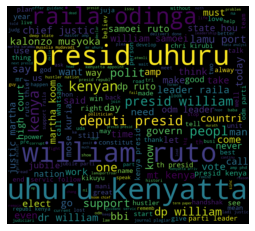

In [63]:
#creating a word cloud
all_words = ' '.join(twts for twts in election_dataset['Stemmed Words'])
wordcloud = WordCloud( width = 1000, height = 900, random_state = 21, max_font_size = 120).generate(all_words)

plt.imshow(wordcloud, interpolation = 'bilinear')
plt.axis('off')
plt.show()

In [64]:
#creating a function that shows subjectivity
def getSubjectivity(text):
    return TextBlob(text).sentiment.subjectivity
#creating a function that shows the polarity
def getPolarity(text):
    return TextBlob(text).sentiment.polarity

election_dataset['Subjectivity'] = election_dataset['Stemmed Words'].apply(getSubjectivity)

election_dataset['Polarity'] = election_dataset['Stemmed Words'].apply(getPolarity)

# function to analyze the reviews
def analysis(score):
    if score < 0:
        return 'Negative'
    elif score == 0:
        return 'Neutral'
    else:
        return 'Positive'



election_dataset.head(3) 

,text,Cleaned Text,POS tagged,Stemmed Words,Subjectivity,Polarity
0,@PrettyAmmina The change to the new blue unifo...,The change to the new blue uniforms was order...,[],chang new blue uniform order presid uhuru keny...,0.277273,0.068182
1,I think it's now safe to say President Uhuru K...,I think it's now safe to say President Uhuru K...,[],think safe say presid uhuru kenyatta amepatia ...,0.500000,0.500000
2,@_CrazyKenyan President Uhuru Kenyatta bribed ...,CrazyKenyan President Uhuru Kenyatta bribed MC...,"[(CrazyKenyan, n)]",crazykenyan presid uhuru kenyatta bribe mca mp...,0.000000,0.000000


In [65]:
fin_data = pd.DataFrame(election_dataset[['text', 'Stemmed Words']])
# fin_data['Subjectivity'] = fin_data['Lemma'].apply(getSubjectivity) 
fin_data['Polarity'] = fin_data['Stemmed Words'].apply(getPolarity) 
fin_data['Analysis'] = fin_data['Polarity'].apply(analysis)
fin_data.head()

,text,Stemmed Words,Polarity,Analysis
0,@PrettyAmmina The change to the new blue unifo...,chang new blue uniform order presid uhuru keny...,0.068182,Positive
1,I think it's now safe to say President Uhuru K...,think safe say presid uhuru kenyatta amepatia ...,0.500000,Positive
2,@_CrazyKenyan President Uhuru Kenyatta bribed ...,crazykenyan presid uhuru kenyatta bribe mca mp...,0.000000,Neutral
3,"As @HonMoses_Kuria has just been saying,Presid...",kuria say presid uhuru kenyatta finish ago mt ...,0.136364,Positive
4,David Murathe the KEMSA thief and President Uh...,david murath kemsa thief presid uhuru kenyatta...,0.000000,Neutral


In [66]:
tb_counts = fin_data.Analysis.value_counts()

tb_counts

Neutral     7340
Positive    3108
Negative    1275
Name: Analysis, dtype: int64

# **Using Vader**

In [78]:
import vaderSentiment
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
analyzer = SentimentIntensityAnalyzer()
# function to calculate vader sentiment
def vadersentimentanalysis(text):
    vs = analyzer.polarity_scores(text)
    return vs['compound']
    fin_data['Vader Sentiment'] = fin_data['Stemmed Words'].apply(vadersentimentanalysis)



# function to analyse
def vader_analysis(compound):
    if compound >= 0.5:
        return 'Positive'
    elif compound <= -0.5 :
        return 'Negative'
    else:
      return 'Neutral'

fin_data.head(3)

,text,Stemmed Words
0,@PrettyAmmina The change to the new blue unifo...,chang new blue uniform order presid uhuru keny...
1,I think it's now safe to say President Uhuru K...,think safe say presid uhuru kenyatta amepatia ...
2,@_CrazyKenyan President Uhuru Kenyatta bribed ...,crazykenyan presid uhuru kenyatta bribe mca mp...


In [74]:
#fin_data = pd.DataFrame(election_dataset[['text', 'Stemmed Words']])
fin_data['Vader Analysis'] = fin_data['Vader Sentiment'].apply(vader_analysis)
fin_data.head()

KeyError: ignored